# Is there a relationship between a person's personality and mushroom consumption?

According to the National Institute of Drug Abuse the drug usage related cost can reach or even exceed the annual $740 billion dollar in the USA: accidents from driving under the influence, crimes caused by or driven by drugs, healthcare cost, or when people dropout from potential workforce. The deaths caused by drug overdose is steadily increasing every year.

Our purpose of the study is to identify the groups of people who are more likely to become users of a certain drug, so that we can reach them with preventive programs or targeted education that can keep them from becoming drug users.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

# libraries for cleaning and preprocessing data
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgb

# libraries for evaluating models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from helper import *
from visualizations import *
from modeling import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Reading Data

In [2]:
drugs = pd.read_csv('data/drug_consumption.data', header=None, index_col=0)

In [3]:
# rename columns
drugs.columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity',
                 'Neuroticism', 'Extraversion', 'Openness-to-experience',
                 'Agreeableness', 'Conscientiousness', 'Impulsive',
                 'Sensation-seeking', 'Alcohol', 'Amphet', 'Amyl', 'Benzos',
                 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy',
                 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
                 'Nicotine', 'Semer', 'VSA']

In [4]:
personality_cols = ['Neuroticism', 'Extraversion', 'Openness-to-experience',
                    'Agreeableness', 'Conscientiousness', 'Impulsive',
                    'Sensation-seeking']

In [5]:
# Convert standardized values into categories
category_converter(drugs)

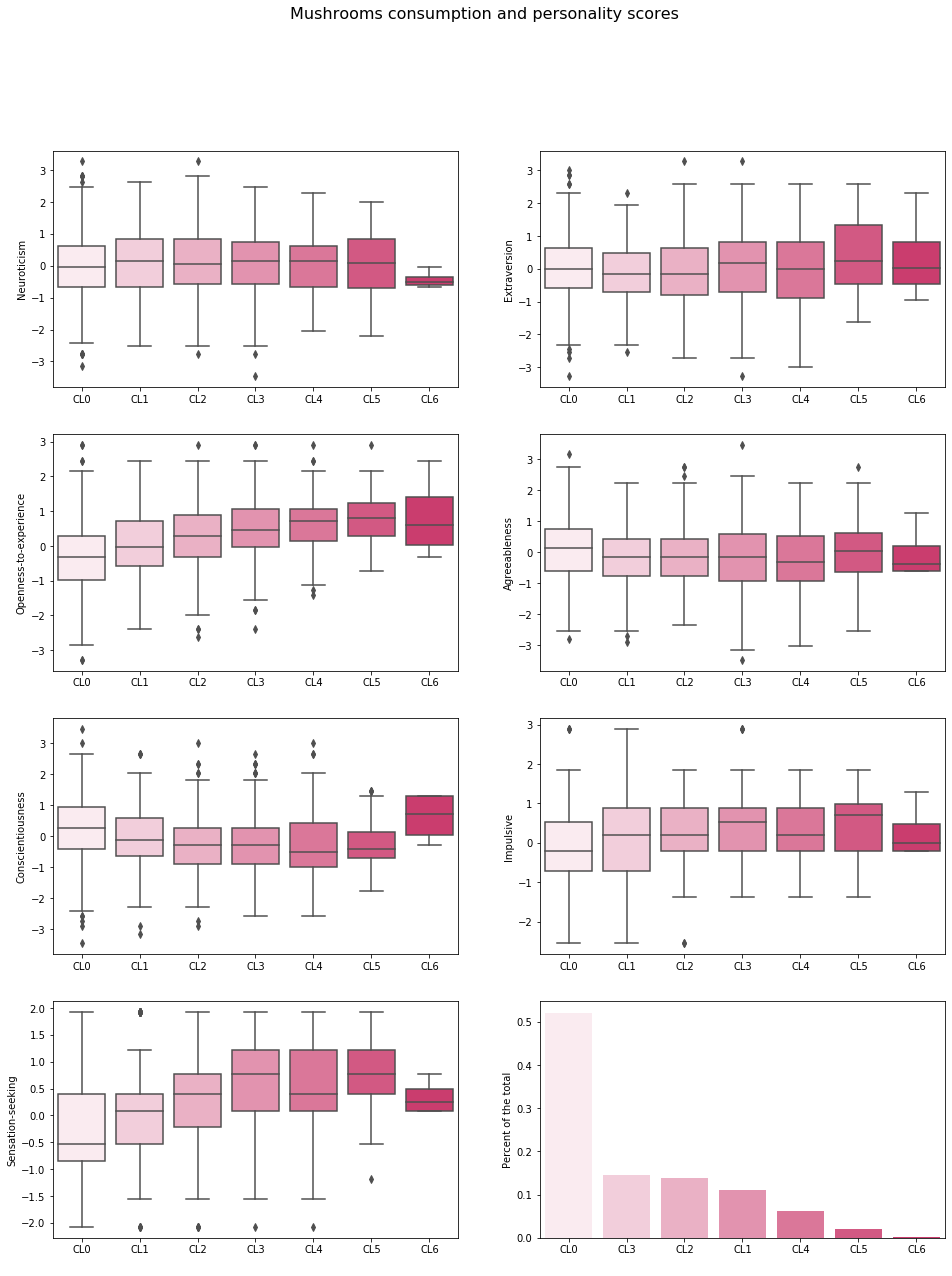

In [6]:
# plot distribution of personalities for each class for mushroom
plot_personality(drugs, personality_cols, 'Mushrooms')

In [7]:
# define drug columns
drug_cols = ['Alcohol', 'Amphet', 'Amyl', 'Benzos',
             'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy',
             'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
             'Nicotine', 'Semer', 'VSA']

# define user and non-user for each drug
for col in drug_cols:
    drugs[f"{col}_User"] = [0 if (x == 'CL0') | (x == 'CL1') else 1
                            for x in drugs[col]]

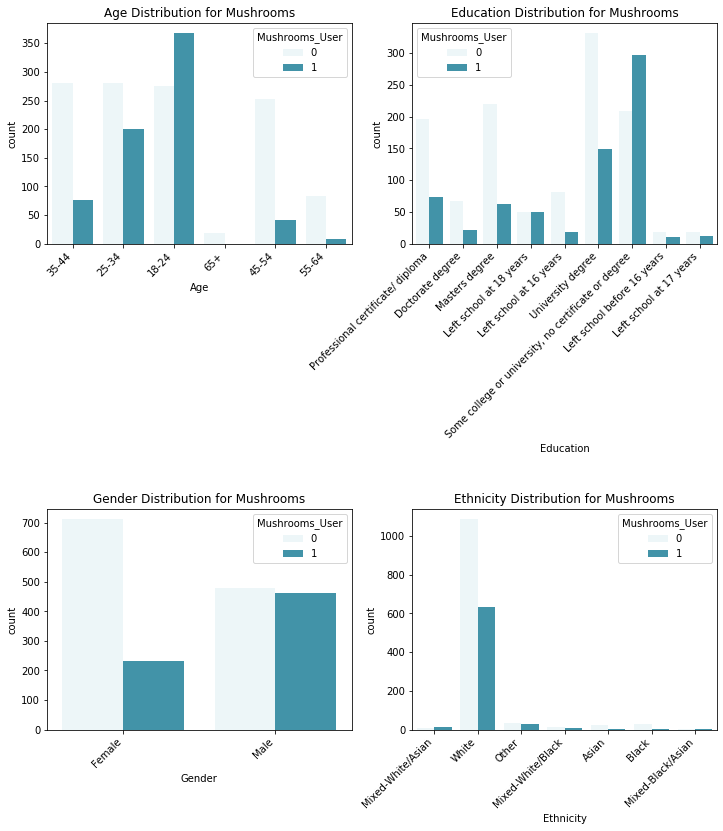

In [8]:
plot_feature_dist(drugs, 'Mushrooms')

In [9]:
drugs = encoding(drugs)

In [10]:
# filter for just <drug name> Users
mushroom = drugs[['Mushrooms_User', 'Age', 'Gender', 'Education',
             'Country', 'Ethnicity'] + personality_cols]

mushroom.rename({'Mushrooms_User': 'User'}, axis=1, inplace=True)
mushroom.drop(columns=['Country', 'Ethnicity'], axis=1, inplace=True)

# save mushroom DataFrame for future use
mushroom.to_csv('data/mushroom.csv', index=False)

In [11]:
sns.reset_orig()

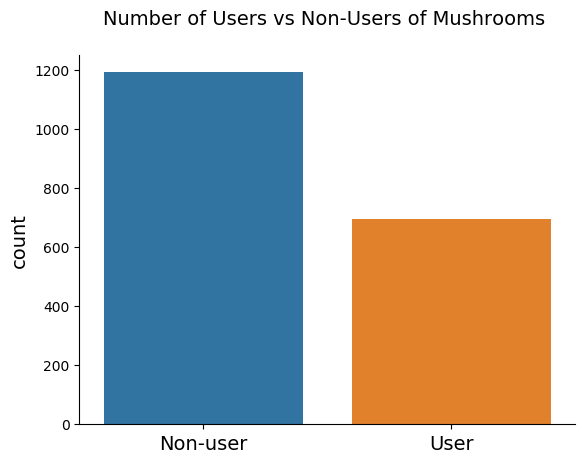

In [12]:
sns.countplot(mushroom['User'])
plt.title(f'Number of Users vs Non-Users of Mushrooms \n',
          fontsize=14)
plt.xticks(np.arange(len(['Non-user', 'User'])),
           labels=['Non-user', 'User'],
           fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xlabel('')
sns.despine(left=False, bottom=False)
plt.savefig('img/users_vs_nonusers - mushroom.png',
            bbox_inches='tight');

## Preprocessing Data

In [13]:
mushroom = pd.read_csv('data/mushroom.csv')
mushroom.head()

,User,Age,Gender,Education,Neuroticism,Extraversion,Openness-to-experience,Agreeableness,Conscientiousness,Impulsive,Sensation-seeking
0,0,2,0,5,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,0,1,1,8,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0,2,1,5,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,0,0,0,7,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,1,2,0,8,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


## Modeling

In [14]:
# define feature and target variables
y = mushroom['User']
X = mushroom.drop('User', axis=1)

In [15]:
# train-test split for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=220)

In [16]:
# scale data for Logistic Regression, KNN, and SVM
X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

scale = StandardScaler()

X_train_scale.loc[:, ['Age', 'Education']] = scale.fit_transform(
    X_train_scale.loc[:, ['Age', 'Education']])
X_test_scale.loc[:, ['Age', 'Education']] = scale.transform(
    X_test_scale.loc[:, ['Age', 'Education']])

### Logistic Regression

In [18]:
grid_log = {'C': [0.005, 0.01, 0.05],
            'penalty': ['l1', 'l2']}

gs_log = run_gridsearch_scaled(LogisticRegression, grid_log,
                               X_train_scale, X_test_scale,
                               y_train, y_test, random_state=220)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.01, 'penalty': 'l2'}
Train score: 0.735
Test score: 0.772


[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


### Random Forest

In [32]:
grid_forest = {'n_estimators': [1000, 1200],
               'max_depth': [12, 15],
               'min_samples_split': [2, 3],
               'min_samples_leaf': [6, 8, 9],
               'max_features': ['log2']}

gs_forest = run_gridsearch(RandomForestClassifier, grid_forest,
                           X_train, X_test, y_train,
                           y_test, random_state=220)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished


Best params: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1200}
Train score: 0.742
Test score: 0.761


### LightGBM

In [21]:
grid_lgb = {'learning_rate': [0.025, 0.05],
            'max_depth': [3, 4],
            'min_child_weight': [6, 7],
            'subsample': [0.1, 0.3]}

gs_lgb = run_gridsearch(lgb.LGBMClassifier, grid_lgb,
                        X_train, X_test, y_train,
                        y_test, random_state=220)

pickle.dump(gs_lgb, open('models/mushroom.sav', 'wb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.2s finished


Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.1}
Train score: 0.738
Test score: 0.769


### KNN

In [25]:
grid_knn = {'n_neighbors': [60, 64, 70]}

gs_knn = run_gridsearch_scaled(KNeighborsClassifier, grid_knn,
                               X_train_scale, X_test_scale,
                               y_train, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'n_neighbors': 64}
Train score: 0.739
Test score: 0.767


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


### SVM

In [28]:
grid_svm = {'C': [0.1, 1, 10],
            'class_weight': ['balanced', None],
            'kernel': ['linear', 'rbf']}

gs_svm = run_gridsearch_scaled('SVM', grid_svm,
                               X_train_scale, X_test_scale,
                               y_train, y_test, random_state=220)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished


Best params: {'C': 1, 'class_weight': None, 'kernel': 'linear'}
Train score: 0.741
Test score: 0.782


## Findings

### ROC Curve

We used Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC) scores to compare which classification method performed the best. The ROC curve shows the ratio of True Positive and False Positive rates. The perfect model (red dotted line) would show an AUC of 1 and a ROC curve that looks like an upside-down 'L', because the perfect model would show 100% True Positives. The black dotted line shows the ROC curve of a random guess.

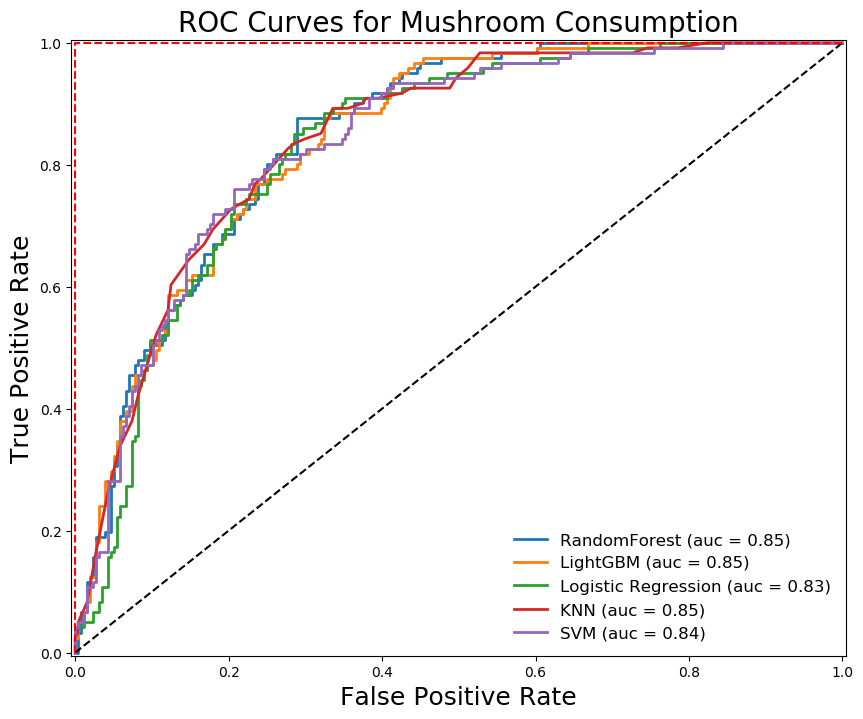

In [33]:
models = [gs_forest, gs_lgb, gs_log, gs_knn, gs_svm]

model_names = ['RandomForest', 'LightGBM',
               'Logistic Regression', 'KNN', 'SVM']

plot_roc_curve(models, model_names, X_test, y_test, 'Mushroom', X_test_scale)

### Interpreting LightGBM Results

I chose to focus on the LightGBM model to analyze the accuracy of predictions and which features are most important in predicting mushroom users.

In [35]:
gs_lgb = pickle.load(open('models/mushroom.sav', 'rb'))

#### Confusion Matrix

The confusion matrix below shows the percent accuracy of predictions. The LightGBM model was 76.9% accurate in predicting whether a person was a user (23%) or a nonuser (54%).

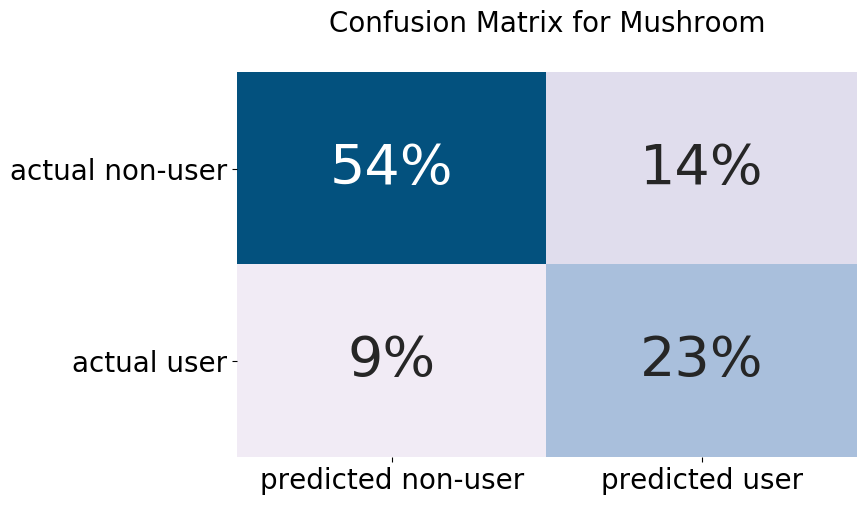

In [37]:
plot_confusion_matrix(y_test, X_test, gs_lgb, 'Mushroom')
plt.savefig('img/mushroom_matrix.png', bbox_inches='tight');

#### Important Features in Predicting Mushroom Users

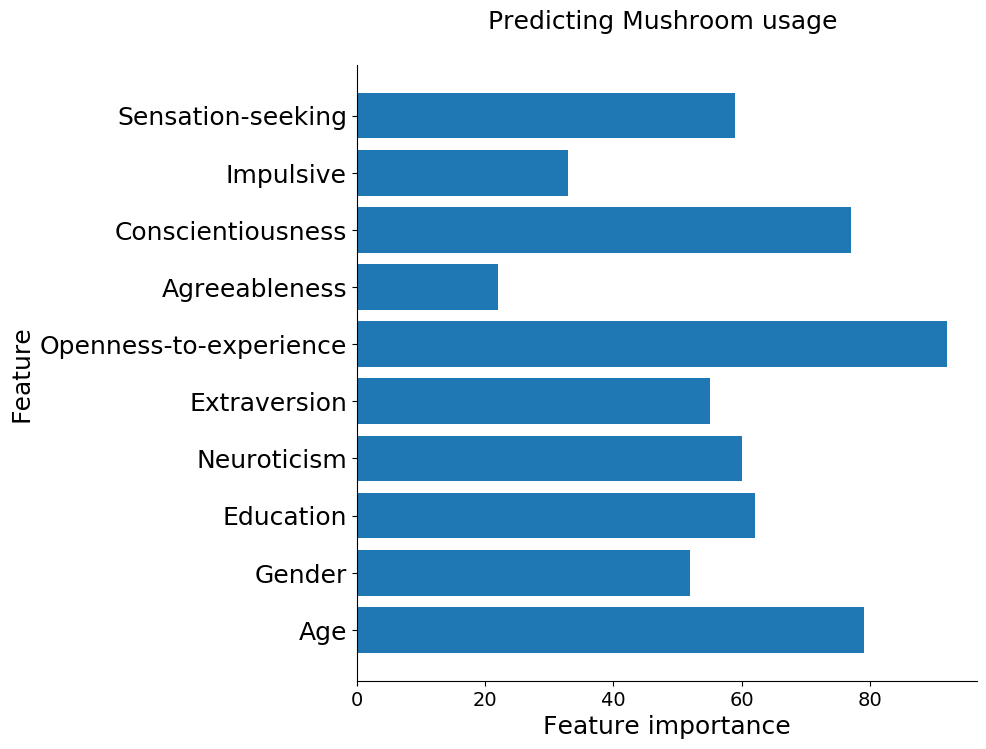

In [38]:
plot_feat_imp(gs_lgb, X_train, 'Mushroom')

## Conclusion

Based on the 5 classification models, their demographics (age, gender, and education level) and their personalities had accuracy levels of 77-78% in predicting mushroom users. Openness to experience and age to experience were the 2 most influential in predicting mushroom consumption.